# Air Fare Prediction 

__Compared to last few decades the passengers travelling via Air mode has increased drastically. Every other airline passenger tries to buy an air ticket at cheapest fare possible.__

&ensp;

<div>
<img src = https://img.washingtonpost.com/rf/image_1484w/2010-2019/WashingtonPost/2017/06/29/Interactivity/Images/iStock-626867464.JPG?uuid=zUBRYlq-EeeqaTlkp9VSBw width="400">
<div/>
 <center> Flight Fares </center>

&ensp;


 To achieve this we have to follow one basic rule that is plan your travel well in advance, but it doesn't always guarantee you end up buying cheapest air fare ticket. And always its not possible to plan our travel in advance. Flight fare in today's world is difficult to predict as it keep varying on frequent basis. 
 
As a Data Scientist, here is the attempt to predict the air fares for various airlines in India.

## Import required Libraries

Let's import relevant libraries.

In [4]:
## Import library
%matplotlib inline

import warnings # To supress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np # Linear algebraa
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plottinga
import seaborn as sns # Visualisation
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [ ]:
# pip install bayesian-optimization


In [79]:
from bayes_opt import BayesianOptimization

## Datasets

We have 2 datasets 'Train' and 'Test', both consists of categorical and numerical variables. 'Train' and 'Test' both contain similar columns except there is no 'Price' column 'Test' dataset as same has to be predicted. Let us load the datasets.

In [5]:
## Load datasets

train_df =  pd.read_excel('/content/sample_data/Data_Train.xlsx')
test_df = pd.read_excel('/content/sample_data/Test_set.xlsx')

### Train Dataset

In [6]:
train_df.shape

(10683, 11)

In [7]:
train_df.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6536,Air India,03/03/2019,Banglore,New Delhi,BLR → CCU → DEL,05:50,12:55,7h 5m,1 stop,No info,12389
7093,Multiple carriers,21/03/2019,Delhi,Cochin,DEL → BOM → COK,11:40,19:15,7h 35m,1 stop,No info,7531
7020,IndiGo,6/06/2019,Kolkata,Banglore,CCU → BLR,09:35,12:10,2h 35m,non-stop,No info,4804
4320,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,09:00,21:00,12h,1 stop,No info,7888
7491,IndiGo,1/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,4226


### Test Dataset

In [8]:
test_df.shape

(2671, 10)

In [9]:
test_df.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
1313,Jet Airways,24/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,19:00,13h 30m,2 stops,In-flight meal not included
2162,GoAir,1/06/2019,Delhi,Cochin,DEL → BOM → COK,10:35,19:35,9h,1 stop,No info
794,Jet Airways,12/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 13 Jun,22h 55m,2 stops,In-flight meal not included
2069,Air India,12/03/2019,Mumbai,Hyderabad,BOM → BLR → HYD,16:50,09:15 13 Mar,16h 25m,1 stop,No info
96,Jet Airways,15/06/2019,Delhi,Cochin,DEL → BOM → COK,15:00,04:25 16 Jun,13h 25m,1 stop,In-flight meal not included


### Combining datasets into one dataset

We will combine test dataset and train dataset so as to work on both datasets at same time. 

In [10]:
combined_df = train_df.append(test_df)
combined_df.reset_index(inplace=True)

In [11]:
combined_df.shape

(13354, 12)

In [12]:
combined_df.sample(3)

,index,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10187,10187,Jet Airways,3/03/2019,Delhi,Cochin,DEL → IDR → BOM → COK,05:25,18:50,13h 25m,2 stops,No info,18799.0
11125,442,Jet Airways,9/05/2019,Kolkata,Banglore,CCU → DEL → BLR,09:35,19:10,9h 35m,1 stop,No info,NaN
11728,1045,Air Asia,6/05/2019,Kolkata,Banglore,CCU → BLR,22:50,01:20 07 May,2h 30m,non-stop,No info,NaN


## Data Wrangling, EDA and Feature Engineering

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            13354 non-null  int64  
 1   Airline          13354 non-null  object 
 2   Date_of_Journey  13354 non-null  object 
 3   Source           13354 non-null  object 
 4   Destination      13354 non-null  object 
 5   Route            13353 non-null  object 
 6   Dep_Time         13354 non-null  object 
 7   Arrival_Time     13354 non-null  object 
 8   Duration         13354 non-null  object 
 9   Total_Stops      13353 non-null  object 
 10  Additional_Info  13354 non-null  object 
 11  Price            10683 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


The "Price" column is __Target Variable__ which has to be predicted in test dataset. The other variables are features.

Additional_Info : Info about type of meal or any other service passenger is willing to opt.

- Airline: __Name of the airline__
- Arrival_Time      
- Date_of_Journey  
- Dep_Time:__Time of Departure___
- Destination
- Source  
- Duration: __Total duration of the flight___
- Route: __Flight will travel via these cities__
- Total_Stops:__Total stops flight will have in the journey___


In [14]:
combined_df.describe()

,index,Price
count,13354.000000,10683.000000
mean,4539.740003,9087.064121
std,3208.707521,4611.359167
min,0.000000,1759.000000
25%,1669.000000,5277.000000
50%,4005.500000,8372.000000
75%,7343.750000,12373.000000
max,10682.000000,79512.000000


_We can see only 'Index' and 'Price' columns are in numeric format._

### Processing Date Column

Date of Journey column is in dd/mm/yyyy format but its datatype is object. We need to convert this column into datetime datatype.

In [15]:
combined_df['Date_of_Journey'] =  pd.to_datetime(combined_df['Date_of_Journey'],format ='%d/%m/%Y')

In [16]:
## Splitting Date 

combined_df['Date'] = combined_df['Date_of_Journey'].dt.day.astype(int)
combined_df['Month'] = combined_df['Date_of_Journey'].dt.month.astype(int)
combined_df['Year'] = combined_df['Date_of_Journey'].dt.year.astype(int)

In [17]:
combined_df.sample(2)

,index,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date,Month,Year
2741,2741,IndiGo,2019-06-12,Delhi,Cochin,DEL → BOM → COK,09:15,21:00,11h 45m,1 stop,No info,6838.0,12,6,2019
9444,9444,Multiple carriers,2019-03-09,Delhi,Cochin,DEL → HYD → COK,09:45,16:10,6h 25m,1 stop,No info,8386.0,9,3,2019


__As we have extracted Date, Month & Year from 'Date_of_Journey' column, we can drop this column.__

In [18]:
combined_df = combined_df.drop(['Date_of_Journey'], axis=1)

In [19]:
combined_df.sample(2)

,index,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date,Month,Year
3099,3099,Jet Airways,Mumbai,Hyderabad,BOM → HYD,19:35,21:05,1h 30m,non-stop,In-flight meal not included,2228.0,1,5,2019
2047,2047,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,10:00,21:00,11h,1 stop,No info,7408.0,9,6,2019


### Processing Price Column

In [20]:
combined_df.isna().sum()

index                 0
Airline               0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
Date                  0
Month                 0
Year                  0
dtype: int64

Let's replace NA values in Price column with mean value.

In [21]:
combined_df['Price'].fillna((combined_df['Price'].mean()), inplace=True)

### Plot 

Let's try to do some analytics by plotting a graph.

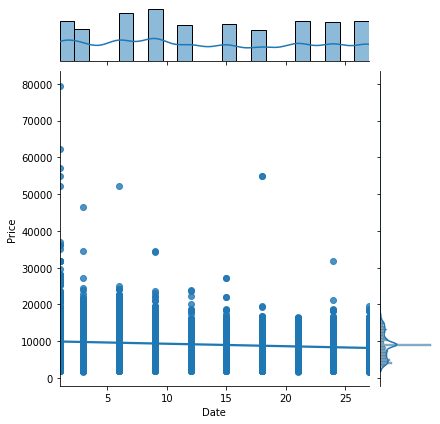

In [22]:
sns.jointplot(x="Date", y="Price" ,kind = 'reg', data=combined_df);

Above plot describes that Ticket fares are slightly cheaper in mid of the month as compared to start and end of the month. Majority of tickets are of the range Rs. 1700 to Rs.18000. There is light negative corelation between Ticket Price and Date.

### Processing Arrival_Time & Dep_Time Columns

__In 'Arrival_Time' column, the time is in combined format of Date & time but we don't need date from it so we will strip date and extract only time from it.__

In [23]:
combined_df['Arrival_Time'] = combined_df['Arrival_Time'] .str.split(' ').str[0]

Extracting 'Hour' & "Minutes' in separate columns from "Arrival_Time" and "Dep_Time".

In [24]:
combined_df['Arrival_Hour'] = combined_df['Arrival_Time'] .str.split(':').str[0].astype(int)
combined_df['Arrival_Minute'] = combined_df['Arrival_Time'] .str.split(':').str[1].astype(int)

In [25]:
combined_df=combined_df.drop(['Arrival_Time'], axis=1)

In [26]:
combined_df['Dep_Hour'] = combined_df['Dep_Time'] .str.split(':').str[0].astype(int)
combined_df['Dep_Minute'] = combined_df['Dep_Time'] .str.split(':').str[1].astype(int)
combined_df=combined_df.drop(['Dep_Time'], axis=1)

### Processing 'Total Stop' Column

__'Total Stop' column contains values such as '2 Stop', '1 Stop', 'non-stop', we will replace 'non stop' with '0 stop' and get only integers out of values.__

In [27]:
combined_df['Total_Stops'] = combined_df['Total_Stops'].fillna('1 stop')

In [28]:
combined_df['Total_Stops']=combined_df['Total_Stops'].replace('non-stop','0 stop')

In [29]:
combined_df['Stop'] = combined_df['Total_Stops'].str.split(' ').str[0].astype(int)

In [30]:
# 'Total_Stops' can be dropped as we have extracted numeric values in 'Stop' 

combined_df=combined_df.drop(['Total_Stops'], axis=1) 

### Processing Route Column

We need to eliminate "→" symbol from 'Route' column and extract city names

In [31]:
combined_df['Route_1'] = combined_df['Route'] .str.split('→ ').str[0]
combined_df['Route_2'] = combined_df['Route'] .str.split('→ ').str[1]
combined_df['Route_3'] = combined_df['Route'] .str.split('→ ').str[2]
combined_df['Route_4'] = combined_df['Route'] .str.split('→ ').str[3]
combined_df['Route_5'] = combined_df['Route'] .str.split('→ ').str[4]

Let's replace NA values in 'Route_n' columns with mean None.

In [32]:
combined_df['Route_1'].fillna("None",inplace = True)
combined_df['Route_2'].fillna("None",inplace = True)
combined_df['Route_3'].fillna("None",inplace = True)
combined_df['Route_4'].fillna("None",inplace = True)
combined_df['Route_5'].fillna("None",inplace = True)

In [33]:
combined_df.describe()

,index,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Stop
count,13354.000000,13354.000000,13354.000000,13354.000000,13354.0,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000
mean,4539.740003,9087.064121,13.389846,4.710574,2019.0,13.396061,24.664146,12.513254,24.507264,0.826045
std,3208.707521,4124.447805,8.439060,1.165622,0.0,6.896145,16.559723,5.736273,18.832385,0.674608
min,0.000000,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1669.000000,6135.250000,6.000000,3.000000,2019.0,8.000000,10.000000,8.000000,5.000000,0.000000
50%,4005.500000,9087.064121,12.000000,5.000000,2019.0,14.000000,25.000000,11.000000,25.000000,1.000000
75%,7343.750000,11087.000000,21.000000,6.000000,2019.0,19.000000,35.000000,18.000000,40.000000,1.000000
max,10682.000000,79512.000000,27.000000,6.000000,2019.0,23.000000,55.000000,23.000000,55.000000,4.000000


### Encoding 

#### Integer Encoding

We will encode categorical data in our dataset to numerical data using Label Encoder.

For this we will import LabelEncoder from sklearn library,then fit and transform the data.

In [34]:
from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
combined_df["Additional_Info"] = lb_encode.fit_transform(combined_df["Additional_Info"])
combined_df["Airline"] = lb_encode.fit_transform(combined_df["Airline"])
combined_df["Destination"] = lb_encode.fit_transform(combined_df["Destination"])
combined_df["Source"] = lb_encode.fit_transform(combined_df["Source"])
combined_df['Route_1']= lb_encode.fit_transform(combined_df["Route_1"])
combined_df['Route_2']= lb_encode.fit_transform(combined_df["Route_2"])
combined_df['Route_3']= lb_encode.fit_transform(combined_df["Route_3"])
combined_df['Route_4']= lb_encode.fit_transform(combined_df["Route_4"])
combined_df['Route_5']= lb_encode.fit_transform(combined_df["Route_5"])

In [35]:
combined_df.sample(5)

,index,Airline,Source,Destination,Route,Duration,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Stop,Route_1,Route_2,Route_3,Route_4,Route_5
8155,8155,4,2,1,DEL → IDR → BOM → COK,13h 30m,5,11507.000000,27,6,2019,19,0,5,30,2,3,21,4,5,4
9496,9496,6,2,1,DEL → BOM → COK,8h,8,17493.000000,3,3,2019,21,0,13,0,1,3,7,6,12,4
4613,4613,8,2,1,DEL → PNQ → COK,4h 30m,7,6356.000000,21,3,2019,13,15,8,45,1,3,38,6,12,4
6162,6162,4,3,0,CCU → DEL → BLR,17h 55m,5,8066.000000,9,5,2019,10,55,17,0,1,2,14,3,12,4
10992,309,3,3,0,CCU → HYD → BLR,4h 50m,8,9087.064121,9,6,2019,20,5,15,15,1,2,20,3,12,4


#### One hot encoding - Dummy encoding

In addition to 'Integer Encoding', we will apply 'Dummy Encoding' to disallow our model to assume any natural ordering between categorie as this may result in poor performance. 

This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

We will apply get_dummies class from Pandas library to each column and then drop original column.

In [36]:
Additional_Info_dummies = pd.get_dummies(combined_df["Additional_Info"], prefix='Additional_Info')    
combined_df = pd.concat([combined_df, Additional_Info_dummies], axis=1)
combined_df.drop('Additional_Info', axis=1, inplace=True)

In [37]:
Airline_dummies = pd.get_dummies(combined_df["Airline"], prefix='Airline')    
combined_df = pd.concat([combined_df, Airline_dummies], axis=1)
combined_df.drop('Airline', axis=1, inplace=True)

In [38]:
Destination_dummies = pd.get_dummies(combined_df["Destination"], prefix='Destination')    
combined_df = pd.concat([combined_df, Destination_dummies], axis=1)
combined_df.drop('Destination', axis=1, inplace=True)

In [39]:
Source_dummies = pd.get_dummies(combined_df["Source"], prefix='Source')    
combined_df = pd.concat([combined_df, Source_dummies], axis=1)
combined_df.drop('Source', axis=1, inplace=True)

In [40]:
Route_1_dummies = pd.get_dummies(combined_df["Route_1"], prefix='Route_1')    
combined_df = pd.concat([combined_df, Route_1_dummies], axis=1)
combined_df.drop('Route_1', axis=1, inplace=True)

In [41]:
Route_2_dummies = pd.get_dummies(combined_df["Route_2"], prefix='Route_2')    
combined_df = pd.concat([combined_df, Route_2_dummies], axis=1)
combined_df.drop('Route_2', axis=1, inplace=True)

In [42]:
Route_3_dummies = pd.get_dummies(combined_df["Route_3"], prefix='Route_3')    
combined_df = pd.concat([combined_df, Route_3_dummies], axis=1)
combined_df.drop('Route_3', axis=1, inplace=True)

In [43]:
Route_4_dummies = pd.get_dummies(combined_df["Route_4"], prefix='Route_4')    
combined_df = pd.concat([combined_df, Route_4_dummies], axis=1)
combined_df.drop('Route_4', axis=1, inplace=True)

In [44]:
Route_5_dummies = pd.get_dummies(combined_df["Route_5"], prefix='Route_5')    
combined_df = pd.concat([combined_df, Route_5_dummies], axis=1)
combined_df.drop('Route_5', axis=1, inplace=True)

In [45]:
combined_df=combined_df.drop(['Route'], axis=1)
combined_df=combined_df.drop(['Duration'], axis=1)

In [46]:
combined_df.sample(5)

,index,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Stop,Additional_Info_0,Additional_Info_1,Additional_Info_2,Additional_Info_3,Additional_Info_4,Additional_Info_5,Additional_Info_6,Additional_Info_7,Additional_Info_8,Additional_Info_9,Airline_0,Airline_1,Airline_2,Airline_3,Airline_4,Airline_5,Airline_6,Airline_7,Airline_8,Airline_9,Airline_10,Airline_11,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Source_0,Source_1,...,Route_3_11,Route_3_12,Route_3_13,Route_3_14,Route_3_15,Route_3_16,Route_3_17,Route_3_18,Route_3_19,Route_3_20,Route_3_21,Route_3_22,Route_3_23,Route_3_24,Route_3_25,Route_3_26,Route_3_27,Route_3_28,Route_3_29,Route_3_30,Route_4_0,Route_4_1,Route_4_2,Route_4_3,Route_4_4,Route_4_5,Route_4_6,Route_4_7,Route_4_8,Route_4_9,Route_4_10,Route_4_11,Route_4_12,Route_4_13,Route_5_0,Route_5_1,Route_5_2,Route_5_3,Route_5_4,Route_5_5
1281,1281,6795.000000,15,6,2019,1,30,19,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1195,1195,10844.000000,6,6,2019,9,20,21,10,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6492,6492,6645.000000,27,3,2019,4,25,8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
10682,10682,11753.000000,9,5,2019,19,15,10,55,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11736,1053,9087.064121,1,4,2019,0,15,22,45,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


### Missing value validation

In [47]:
combined_df.isna().sum()

index        0
Price        0
Date         0
Month        0
Year         0
            ..
Route_5_1    0
Route_5_2    0
Route_5_3    0
Route_5_4    0
Route_5_5    0
Length: 146, dtype: int64

## TEST TRAIN SPLIT

Let's separate out train set and test set from the combined dataset

In [48]:
# Split it into test and train

df_train = combined_df[0:10683]
df_test = combined_df[10683:]
df_test = df_test.drop(['Price'], axis =1)

In [49]:
X = df_train.drop(['Price'], axis=1)
y = df_train.Price

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## MODEL BUILDING 

We will try different models and compare the "RMSE" score for each model.

We are going to try below ML algorithms :
- LinearRegression
- Ridge Regression
- Lasso Regression
- Elastic Net Regularization
- Extreme Gradient Boosting (XGBoost)
- Light GBM


In [51]:
lin_reg = LinearRegression() #LinearRegression
rig_cv = RidgeCV() #Ridge Regression
lasso = LassoCV() #Lasso Regression
elastic = ElasticNetCV() #Elastic Net Regularization
xgb = XGBRegressor() #Extreme Gradient Boosting (XGBoost)
lig_gbm = LGBMRegressor() #Light GBM

models = [lin_reg, rig_cv, lasso, elastic, xgb, lig_gbm]

In [52]:
#Build our cross validation method
kfolds = KFold(n_splits=50,shuffle=True, random_state=0)

In [53]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

In [66]:
from sklearn.metrics import mean_squared_error

acc = []
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = cv_rmse(model).mean()
    acc.append(score)
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.linear_model._base.LinearRegression'>
CV score = 2326.90161121122
****
Cross-validation of : <class 'sklearn.linear_model._ridge.RidgeCV'>
CV score = 2324.675984112096
****
Cross-validation of : <class 'sklearn.linear_model._coordinate_descent.LassoCV'>
CV score = 2881.378872895002
****
Cross-validation of : <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>
CV score = 4520.902410663658
****
Cross-validation of : <class 'xgboost.sklearn.XGBRegressor'>
[11:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

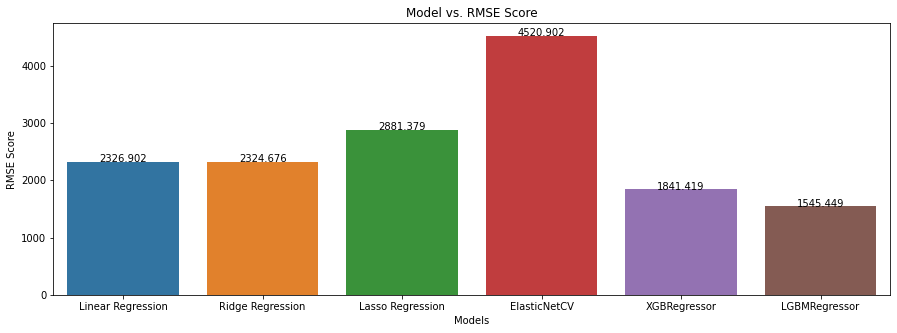

In [67]:
model_name = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNetCV', 'XGBRegressor', 'LGBMRegressor']
accuracy = dict(zip(model_name, acc))

plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() /2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("RMSE Score")
plt.title("Model vs. RMSE Score")
plt.show()

From the above, after applying different Regression models we can see Lightgbm is performing really good as compared to others.

So we will use __'Lightgbm'__ to predict our test data

**RMSE Score for Test set with LGBM Regressor before hyperparameter tuning**

In [69]:
lig_gbm.fit(X_train,y_train)
y_pred_xgb = lig_gbm.predict(X_test)
score = np.sqrt(-cross_val_score(lig_gbm, X_test, y_test, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds)).mean()
                        
print(score)

1787.3549084402466


**Hyperparameter tuning for LGBM Regressor**


In [84]:
def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 100):
  dtrain = lgb.Dataset(data=X_test, label=y_test)
  def lgb_r2_score(preds, dtrain):
      labels = dtrain.get_label()
      return 'r2', r2_score(labels, preds), True
  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        
          params = {'application':'regression','num_iterations': num_iterations,
                    'learning_rate':0.05, 'early_stopping_round':50,
                    'metric':'lgb_r2_score'} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['max_depth'] = int(round(max_depth))
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
                              verbose_eval =None, feval=lgb_r2_score)
           #print(cv_results)
          return np.max(cv_results['r2-mean'])
  # Domain space-- Range of hyperparameters 
  pds = {'num_leaves': (80, 100),
            'feature_fraction': (0.1, 0.9),
            'bagging_fraction': (0.8, 1),
            'max_depth': (17, 25),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (10, 25)
            }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)
  optimizer.max['params']

bayesion_opt_lgbm(X, y, init_iter=5, n_iters=10, random_state=77, seed = 101, num_iterations = 200)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
{'r2-mean': [0.05601941387294753, 0.1162249725078085, 0.16924507500288058, 0.21733977357091394, 0.26177885206683293, 0.3044701304424301, 0.3435234822379548, 0.3807550871309798, 0.4112868104217058, 0.44176511852927386, 0.46844959298507155, 0.4928384689584937, 0.5154912571232281, 0.5358122767363913, 0.553368927550233, 0.5684385223113757, 0.5818075984972894, 0.5951320093936895, 0.6115567800887751, 0.6223744775122653, 0.6319378009922506, 0.6395941223661092, 0.6484586365946352, 0.6589542673194198, 0.6661221185546033, 0.6727202449781329, 0.681238248007946, 0.689587835534803, 0.6973794210635703, 0.7054482142641135, 0.7116604094594872, 0.7163414786122927, 0.721794627712379, 0.7265232098027875, 0.7300493818416569, 0.7327345548700535, 0.7374488214718598, 0.7398800129035599, 0.7424956448678677, 0.7458065

Let's apply above model to predict "Price" for original test dataset.

In [ ]:
df_test_lig_gbm = df_test
lig_gbm_pred = lig_gbm.predict(df_test)
df_test_lig_gbm['Price'] = lig_gbm_pred
df_test_lig_gbm.to_csv('flight_price_pred.csv')

## To Conclude

In such work around, Feature Engineering plays an important role. Also here we have used dual encoding techniques to increase our model's performance.

We compared RMSE score for each model and then selected the model with better RMSE score to apply on our test dataset.

Advanced techniques like Pipeline, Stacking etc. can be used to tune algorithm and improve the performance of the model.

Further, Hyperparameter tuning can be performed to fine tune our alogorithm and get best performance score from the model.

**Credits & References:**

https://medium.com/code-to-express/flight-price-prediction-7c83616a13bb

https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9

